<a href="https://colab.research.google.com/github/CelikAbdullah/my-deep-learning-notebooks/blob/main/image%20classification/Image_Classification_with_the_Fashion_MNIST_dataset_using_a_model_with_residual_blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

# Getting the Fashion MNIST dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

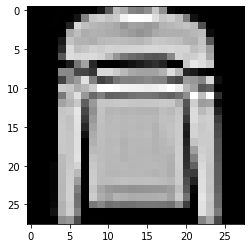

In [5]:
plt.imshow(x_train[5], cmap=plt.get_cmap('gray'))
plt.show()

# Creating a validation dataset

In [6]:
x_val = x_train[:10000]
x_train = x_train[10000:]

y_val = y_train[:10000]
y_train = y_train[10000:]

In [7]:
x_train.shape, x_val.shape, x_test.shape

((50000, 28, 28), (10000, 28, 28), (10000, 28, 28))

In [8]:
y_train.shape, y_val.shape, y_test.shape

((50000,), (10000,), (10000,))

# Preparing the data

In [9]:
x_train = x_train.reshape((50000, 28, 28, 1))
x_train = x_train.astype("float32") / 255

x_val = x_val.reshape((10000, 28, 28, 1))
x_val = x_val.astype("float32") / 255

x_test = x_test.reshape((10000, 28, 28, 1))
x_test = x_test.astype("float32") / 255

# Building a model with residual blocks

In [29]:
# a helper function 
def residual_block(x, num_filters, pooling = False):
  # residual is pointing to the original input
  residual = x

  # a block containing conv layers
  x = keras.layers.SeparableConv2D(num_filters, 3, padding="same", use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)
  x = keras.layers.SeparableConv2D(num_filters, 3, padding="same", use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)
  x = keras.layers.SeparableConv2D(num_filters, 3, padding="same", use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation("relu")(x)

  if pooling: 
    x = keras.layers.MaxPooling2D(2, padding="same")(x)
    residual = keras.layers.Conv2D(num_filters, 1, strides=2)(residual)

  elif num_filters != residual.shape[-1]:
    residual = keras.layers.Conv2D(num_filters, 1)(residual)

  x = keras.layers.add([x, residual])

  return x

In [30]:
num_classes = 10

inputs = keras.Input(shape=(28,28,1))

x = keras.layers.Conv2D(16,3,padding="same", use_bias=False)(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(2)(x)


x = residual_block(x, 32, True)
x = residual_block(x, 64, True)
x = residual_block(x, 128, True)
x = residual_block(x, 256, True)
x = residual_block(x, 512, True)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

model_with_residual_blocks = keras.Model(inputs=inputs, outputs=outputs, name="model_with_residual_blocks")

In [31]:
model_with_residual_blocks.summary()

Model: "model_with_residual_blocks"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_128 (Conv2D)            (None, 28, 28, 16)   144         ['input_10[0][0]']               
                                                                                                  
 batch_normalization_97 (BatchN  (None, 28, 28, 16)  64          ['conv2d_128[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_96 (Activation)     (None, 28, 28, 16)   0           ['batch_

# Compiling the model

In [32]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

model_with_residual_blocks.compile(optimizer=optimizer, loss=loss, metrics=metrics)


# Setting up some callbacks

In [33]:
callbacks = [
             keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/fashion_mnist/fashion_mnist_model_with_residual_blocks", 
                                             save_best_only=True, 
                                             monitor ="val_loss"), 
             keras.callbacks.EarlyStopping(patience=10), 
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
]

In [34]:
history_model_with_residual_blocks= model_with_residual_blocks.fit(x=x_train, 
                        y=y_train, 
                        batch_size=128, 
                        epochs=100, 
                        callbacks=callbacks, 
                        validation_data=(x_val, y_val)
                        )

Epoch 1/100
391/391 [==============================] - 192s 485ms/step - loss: 0.7540 - accuracy: 0.7399 - val_loss: 2.1907 - val_accuracy: 0.1303 - lr: 0.0010
Epoch 2/100
391/391 [==============================] - 189s 485ms/step - loss: 0.4143 - accuracy: 0.8516 - val_loss: 0.3891 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 3/100
391/391 [==============================] - 191s 488ms/step - loss: 0.3556 - accuracy: 0.8706 - val_loss: 0.3488 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 4/100
391/391 [==============================] - 191s 488ms/step - loss: 0.3200 - accuracy: 0.8840 - val_loss: 0.3440 - val_accuracy: 0.8721 - lr: 0.0010
Epoch 5/100
391/391 [==============================] - 189s 484ms/step - loss: 0.2939 - accuracy: 0.8928 - val_loss: 0.3121 - val_accuracy: 0.8835 - lr: 0.0010
Epoch 6/100
391/391 [==============================] - 190s 485ms/step - loss: 0.2760 - accuracy: 0.8995 - val_loss: 0.3033 - val_accuracy: 0.8885 - lr: 0.0010
Epoch 7/100
391/391 [===================

# Plotting the results

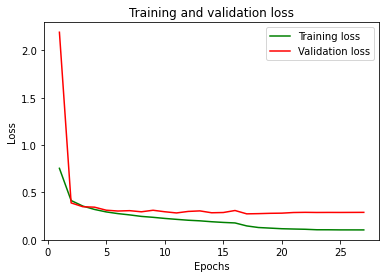

In [36]:
history = history_model_with_residual_blocks.history

train_loss = history["loss"]
val_loss = history["val_loss"]

train_acc = history["accuracy"]
val_acc = history["val_accuracy"]

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, linestyle="solid", color="green", label="Training loss")
plt.plot(epochs, val_loss, linestyle="solid", color="red", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

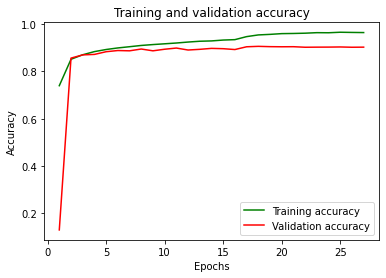

In [37]:
plt.clf()

plt.plot(epochs, train_acc, linestyle="solid", color="green", label="Training accuracy")
plt.plot(epochs, val_acc, linestyle="solid", color="red", label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [40]:
model = keras.models.load_model("/content/drive/MyDrive/fashion_mnist/fashion_mnist_model_with_residual_blocks")

In [41]:
test_loss, test_acc = model.evaluate(x=x_test, y=y_test)
print(f"The test accuracy on new unseen data is {test_acc}")

313/313 [==============================] - 7s 22ms/step - loss: 0.3022 - accuracy: 0.8972
The test accuracy on new unseen data is 0.8971999883651733
